# **Tutorial Fine-Tuning Model Bahasa** 🦜

## 1. Pendahuluan
**Apa itu Fine-Tuning?**
Fine-tuning adalah proses menyesuaikan model bahasa yang sudah dilatih sebelumnya (pre-trained) untuk tugas spesifik dengan melatihnya lagi pada dataset yang lebih kecil.

**Mengapa DistilBERT?**
- Model yang lebih ringan dari BERT tetapi mempertahankan 95% performa
- Cocok untuk pemula karena lebih cepat dalam pelatihan
- Sudah terbukti baik untuk tugas klasifikasi teks

## 2. Persiapan Environment

### Instalasi Library

**Penjelasan:**

- **`transformers`**: Library dari HuggingFace untuk model NLP

- **`datasets`**: Untuk memuat dataset

- **`torch`**: Framework deep learning PyTorch

- **`scikit-learn`**: Untuk metrik evaluasi

In [ ]:
!pip install -U transformers datasets torch
!pip3 install torch torchvision torchaudio # untuk Komputer biasa dan MacOS M series processor
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 # untuk Windows dengan CUDA NVIDIA (sesuaikan dengan versi CUDA)
# info tentang versi CUDA dan PyTorch lainnya : https://pytorch.org/get-started/locally/
!pip install 'transformers[torch]' accelerate
!pip install scikit-learn

## 3. Memuat dan Memahami Data
### Load Dataset IMDB

In [2]:
from datasets import load_dataset

### Apa itu Dataset IMDB?

- Kumpulan 50,000 review film

- Label: 1 (positif) atau 0 (negatif)

- Sudah terbagi menjadi train (25,000) dan test (25,000)

### Struktur Data:

- **`text`**: Review film dalam bentuk teks

- **`label`**: Sentimen (0/1)

In [18]:
dataset = load_dataset("imdb")  # Contoh dataset
print(dataset["train"][1])  # Lihat contoh data

{'text': '"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, 

## 4. Persiapan Model & Tokenizer

### Load Model
**Parameter:**

- **`num_labels=2`**: Karena kita punya 2 kelas (positif/negatif)

**Arsitektur DistilBERT:**

- 6 layer transformer (BERT base punya 12)

- Dimensionality 768 (sama seperti BERT base)

- Menggunakan knowledge distillation

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenisasi
**Penjelasan:**

1. **`AutoTokenizer`**: Memuat tokenizer yang sesuai dengan model DistilBERT

2. **`preprocess_function`**:

    - **`truncation=True`**: Potong teks jika melebihi max_length

    - **`padding="max_length"`**: Tambahkan padding sampai max_length

    - **`max_length=256`**: Panjang maksimum teks input

    - **`map()`**: Terapkan fungsi ke seluruh dataset

    - **`rename_column`**: Ubah nama kolom label untuk kompatibilitas

In [ ]:
# Tokenisasi
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_datasets = tokenized_dataset.rename_column("label", "labels")

## 5. Setup Pelatihan


In [ ]:
from transformers import TrainingArguments, Trainer, TrainerCallback
import numpy as np
from sklearn.metrics import accuracy_score

### Training Arguments
**Penjelasan Parameter:**

- **`learning_rate=2e-5`**: Learning rate kecil karena fine-tuning

- **`batch_size=16`**: Jumlah sampel per batch

- **`num_train_epochs=3`**: Jumlah epoch pelatihan

- **`evaluation_strategy="epoch"`**: Evaluasi tiap akhir epoch



In [ ]:
# Training Configuration
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    eval_steps=None,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",  # Disable external logging services
    disable_tqdm=False,
)

### Fungsi Evaluasi

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


**Cara Kerja:**

1. Ambil label sebenarnya

2. Ambil prediksi (kelas dengan probability tertinggi)

3. Hitung akurasi

### Pembuatan Custom Callback

Class `FixedMetricsCallback` merupakan custom callback untuk menyimpan metrik pelatihan dan evaluasi selama proses fine-tuning. Callback adalah fungsi yang dipanggil pada tahap-tahap tertentu selama pelatihan model.

**Komponen Utama:**

1. `metrics_history`: List untuk menyimpan semua metrik pelatihan/evaluasi

2. `current_epoch`: Penanda epoch saat ini

In [ ]:
# Membuat class untuk menyimpan metrik
class FixedMetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics_history = []
        self.current_epoch = 0  # Mulai dari 0
    
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.current_epoch += 1
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if "loss" in logs:  # Training log
                self.metrics_history.append({
                    "type": "training",
                    "step": state.global_step,
                    "loss": logs["loss"],
                    "epoch": self.current_epoch
                })
            elif "eval_loss" in logs:  # Evaluation log
                logs.update({
                    "type": "evaluation",
                    "epoch": self.current_epoch,
                    "step": state.global_step
                })
                self.metrics_history.append(logs)

### Inisialisasi Trainer

In [ ]:
# Make Trainer
metrics_callback = FixedMetricsCallback()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback],
)

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 6. Fine Tuning dan Evaluasi

### Mulai Pelatihan

In [ ]:
# Train and Evaluate
print("Starting training...")
try:
    trainer.train()
except Exception as e:
    print(f"Training error: {str(e)}")


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,
1,0.257800,0.257919,0.895920,1563
2,0.168000,0.280470,0.913320,3126
3,0.115500,0.334310,0.915440,4689


**Apa yang terjadi:**

1. Model akan melalui data training sebanyak 3 epoch

2. Setiap epoch akan dievaluasi pada data test

3. Model dengan akurasi terbaik akan disimpan

In [ ]:
# Print Training History with Validation
for entry in metrics_callback.metrics_history:
    # epoch = entry['epoch']
    if entry["type"] == "training":
        print(f"Epoch {entry['epoch']} - Step {entry['step']}: Train Loss = {entry['loss']:.4f}")
        epoch = entry['epoch']
    else:
        print(f"Epoch {epoch} Evaluation:")
        print(f"  Loss: {entry['eval_loss']:.4f}")
        print(f"  Accuracy: {entry['eval_accuracy']:.4f}")

# metrics_callback.metrics_history

Epoch 1 - Step 100: Train Loss = 0.4721
Epoch 1 - Step 200: Train Loss = 0.3186
Epoch 1 - Step 300: Train Loss = 0.3452
Epoch 1 - Step 400: Train Loss = 0.2967
Epoch 1 - Step 500: Train Loss = 0.2814
Epoch 1 - Step 600: Train Loss = 0.2872
Epoch 1 - Step 700: Train Loss = 0.2851
Epoch 1 - Step 800: Train Loss = 0.2702
Epoch 1 - Step 900: Train Loss = 0.2386
Epoch 1 - Step 1000: Train Loss = 0.2954
Epoch 1 - Step 1100: Train Loss = 0.2738
Epoch 1 - Step 1200: Train Loss = 0.2810
Epoch 1 - Step 1300: Train Loss = 0.2450
Epoch 1 - Step 1400: Train Loss = 0.2549
Epoch 1 - Step 1500: Train Loss = 0.2578
Epoch 1 Evaluation:
  Loss: 0.2579
  Accuracy: 0.8959
Epoch 2 - Step 1600: Train Loss = 0.2207
Epoch 2 - Step 1700: Train Loss = 0.1821
Epoch 2 - Step 1800: Train Loss = 0.1526
Epoch 2 - Step 1900: Train Loss = 0.1983
Epoch 2 - Step 2000: Train Loss = 0.1598
Epoch 2 - Step 2100: Train Loss = 0.1612
Epoch 2 - Step 2200: Train Loss = 0.1889
Epoch 2 - Step 2300: Train Loss = 0.1563
Epoch 2 - St

### Evaluasi Model

In [17]:
print("\nRunning final evaluation...")
try:
    eval_results = trainer.evaluate()
    print("\nFinal Evaluation Results:")
    print(f"Loss: {eval_results['eval_loss']:.4f}")
    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
except Exception as e:
    print(f"Evaluation error: {str(e)}")


Running final evaluation...



Final Evaluation Results:
Loss: 0.3343
Accuracy: 0.9154


# Evaluasi model SEBELUM fine-tuning

In [19]:
# Evaluasi model SEBELUM fine-tuning
print("Evaluating model BEFORE fine-tuning...")
pre_finetune_trainer = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2),
    args=training_args,
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)
pre_finetune_results = pre_finetune_trainer.evaluate()
print("\nEvaluation Results BEFORE Fine-Tuning:")
print(f"Loss: {pre_finetune_results['eval_loss']:.4f}")
print(f"Accuracy: {pre_finetune_results['eval_accuracy']:.4f}")

# Evaluasi model SETELAH fine-tuning
print("\nEvaluating model AFTER fine-tuning...")
post_finetune_results = trainer.evaluate()
print("\nEvaluation Results AFTER Fine-Tuning:")
print(f"Loss: {post_finetune_results['eval_loss']:.4f}")
print(f"Accuracy: {post_finetune_results['eval_accuracy']:.4f}")

# Membandingkan hasil
print("\nComparison of Results:")
print(f"Loss BEFORE Fine-Tuning: {pre_finetune_results['eval_loss']:.4f}")
print(f"Loss AFTER Fine-Tuning: {post_finetune_results['eval_loss']:.4f}")
print(f"Accuracy BEFORE Fine-Tuning: {pre_finetune_results['eval_accuracy']:.4f}")
print(f"Accuracy AFTER Fine-Tuning: {post_finetune_results['eval_accuracy']:.4f}")

Evaluating model BEFORE fine-tuning...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Results BEFORE Fine-Tuning:
Loss: 0.6941
Accuracy: 0.5014

Evaluating model AFTER fine-tuning...

Evaluation Results AFTER Fine-Tuning:
Loss: 0.3343
Accuracy: 0.9154

Comparison of Results:
Loss BEFORE Fine-Tuning: 0.6941
Loss AFTER Fine-Tuning: 0.3343
Accuracy BEFORE Fine-Tuning: 0.5014
Accuracy AFTER Fine-Tuning: 0.9154


## Visualisasi

Matplotlib is building the font cache; this may take a moment.


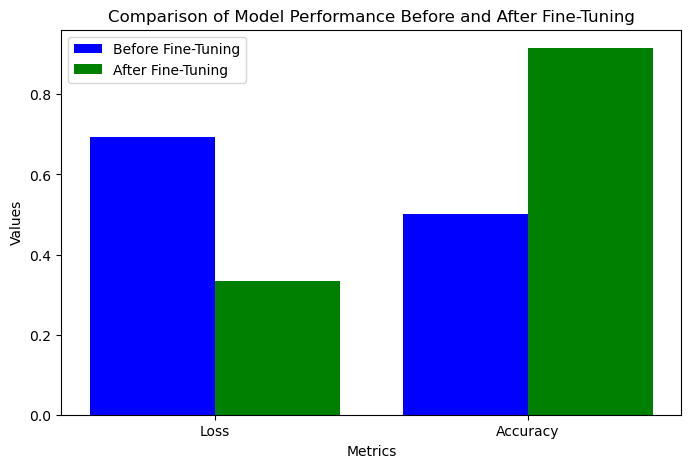

In [20]:
import matplotlib.pyplot as plt

# Data untuk visualisasi
labels = ['Loss', 'Accuracy']
before_finetuning = [pre_finetune_results['eval_loss'], pre_finetune_results['eval_accuracy']]
after_finetuning = [post_finetune_results['eval_loss'], post_finetune_results['eval_accuracy']]

x = range(len(labels))  # Posisi untuk sumbu x

# Membuat plot
plt.figure(figsize=(8, 5))
plt.bar(x, before_finetuning, width=0.4, label='Before Fine-Tuning', color='blue', align='center')
plt.bar([p + 0.4 for p in x], after_finetuning, width=0.4, label='After Fine-Tuning', color='green', align='center')

# Menambahkan label dan judul
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Model Performance Before and After Fine-Tuning')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()

# Menampilkan plot
plt.show()